In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-detection/keras/default/1/model_trained.h5
/kaggle/input/testing/image1.png


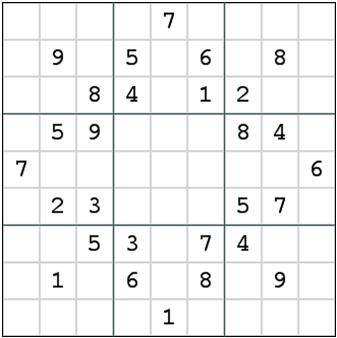

In [2]:
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import cv2
%matplotlib inline
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load the model
image_path = "/kaggle/input/testing/image1.png"
height = 450
width = 450
model = load_model("/kaggle/input/digit-detection/keras/default/1/model_trained.h5")



2024-08-16 04:55:24.619722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 04:55:24.619852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 04:55:24.769138: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import cv2

def display_images(images, titles=None, cols=3):
    """Display a list of images in a grid using matplotlib."""
    n = len(images)
    rows = (n + cols - 1) // cols  

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
      # if there's only one subplot, `axes` is a single `Axes` object, not an array
    if rows == 1 and cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten() 
    for i, (image, ax) in enumerate(zip(images, axes)):
        # convert BGR to RGB for matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image_rgb, cmap='gray')
        if titles:
            ax.set_title(titles[i])
        ax.axis('off')

  
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# Sudoku Image Preprocessing
1. Conversion to grayscale
2. Blurring: This step reduces the detail and noise in an image, this results in a simpler image which is better to analyze and process.
3. Thresholding: Creates a binary image from a grayscale image. Adaptive thresholding finds a local threshold value for each pixel based on its neighborhood and converts it into two distinct values. 


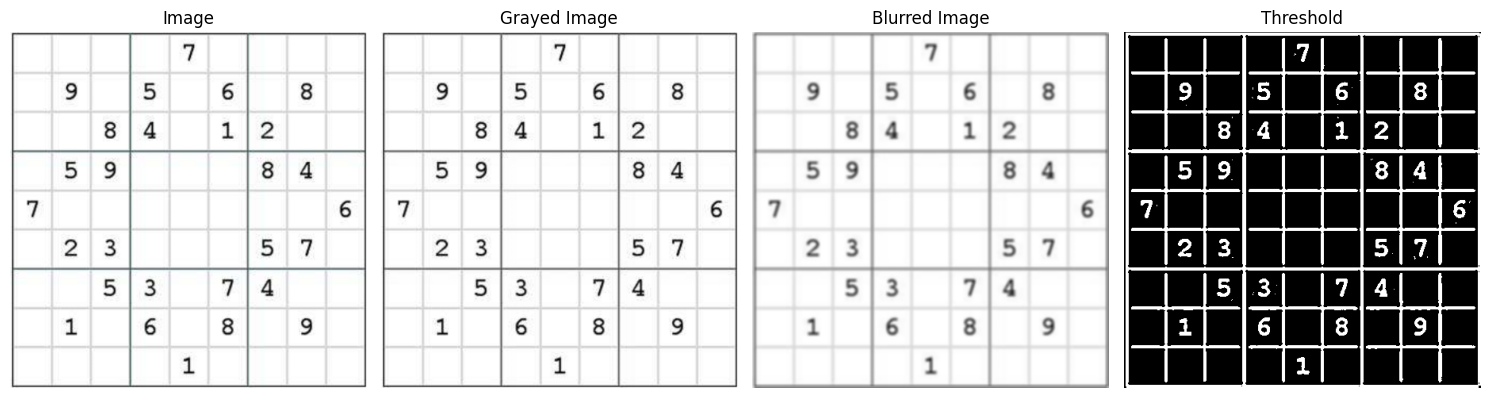

In [4]:

blank_image = np.zeros((height, width, 3), np.uint8)
image = cv2.imread(image_path)
image = cv2.resize(image, (height, width))


image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_blur = cv2.GaussianBlur(image_gray, (5, 5), 2)
image_threshold = cv2.adaptiveThreshold(image_blur, 255, 1, 1, 11, 2)
# 255: Maximum value to be assigned to pixels that exceed the threshold
# 1: 1 corresponds to cv2.ADAPTIVE_THRESH_MEAN_C. The threshold value for each pixel is the mean of the pixel values in the local neighborhood minus the constant C.
# 1: 1 corresponds to cv2.THRESH_BINARY, pixels above the threshold are set to maxValue 255, and pixels below are set to 0.
# 11: The size of the local neighborhood used to calculate the threshold.
# 2: The constant C subtracted from the calculated mean or weighted mean.

image_array = [image, image_gray, image_blur, image_threshold]
titles = ['Image', 'Grayed Image', 'Blurred Image', 'Threshold']
display_images(image_array, titles=titles, cols=4)

# Finding Contours
Contours represent the outlines of objects and can help identify their shapes, locations, boundaries, areas, and helps segmant images into different regions based on the countours. 

First we retrieve the outermost contours of the puzzle to get the outer contours of the entire Sudoku. Then we draw these contours onto a copy of the original image  to visualize them. With the contours found, we will find the coordinates of the biggest contour which will most likely be the main Sudoku puzzle grid. Filter out small contours and simplify the contours further to make sure the largest area of contour with exactly 4 vertices are chosen, representing the biggest contour which is assumed to be the shape of the puzzle grid.

Reordering points:
Adding up the coordinates
[  4 452 895 452]
Subtracting the coordinates
[[   0]
 [ 446]
 [   3]
 [-446]]
Coordinates of the biggest contour
[[[  2   2]]

 [[449   3]]

 [[  3 449]]

 [[446 449]]]


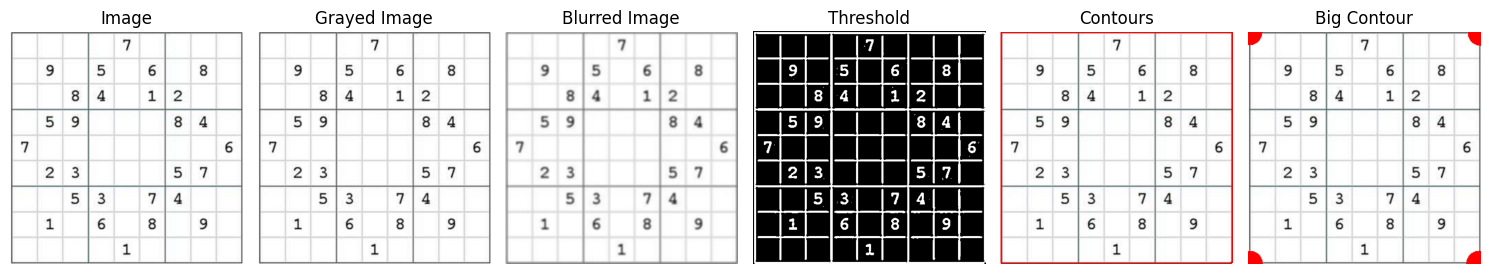

In [5]:
image_contours = image.copy() 
big_contour_image = image.copy()

# cv2.RETR_EXTERNAL: retrieves only the outermost contours.
# cv2.CHAIN_APPROX_SIMPLE: compresses horizontal, vertical, and diagonal segments to retain only their end points.
contours, _ = cv2.findContours(image_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(image_contours, contours, -1, (0, 0, 255), 2)

# send in all contours found
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0

    for i in contours: 
        area = cv2.contourArea(i)  

        if area > 50: # contour can't be too small, or its just noise
            perim = cv2.arcLength(i, True) 
            approx = cv2.approxPolyDP(i, 0.02 * perim, True) # approximates contour by removing vertices, but keeping shape
            # epsilon value allows control for level of simplificatoin. Within 2% of original contour
            # returns simplifed polygonal curve

            if area > max_area and len(approx) == 4: # len(approx) == 4, lets us only find rectangles or squares
                biggest = approx
                max_area = area

    return biggest, max_area # biggest will contain corner points




biggest, max_area = biggestContour(contours)

def reorder(my_points):
    my_points = my_points.reshape((4,2)) 
    my_points_new = np.zeros((4, 1, 2), dtype=np.int32) 
    add = my_points.sum(axis=1)     
    print("Reordering points:")
    print("Adding up the coordinates")
    print(add)
    diff = np.diff(my_points, axis=1)
    print("Subtracting the coordinates")
    print(diff)
    
    top_left = np.argmin(add)
    bottom_right = np.argmax(add)

    top_right = np.argmin(diff)
    bottom_left = np.argmax(diff)
    
    my_points_new[0] = my_points[top_left]
    my_points_new[1] = my_points[top_right]
    my_points_new[2] = my_points[bottom_left]
    my_points_new[3] = my_points[bottom_right]


    return my_points_new


if biggest.size != 0:
    biggest = reorder(biggest) 
    print("Coordinates of the biggest contour")
    print(biggest)

    cv2.drawContours(big_contour_image, biggest, -1, (0, 0, 255), 50)
    
image_array = [image, image_gray, image_blur, image_threshold, image_contours, big_contour_image]
titles = ['Image', 'Grayed Image', 'Blurred Image', 'Threshold', 'Contours', 'Big Contour']
display_images(image_array, titles=titles, cols=6)


<a id="section1"></a>
# Detecting the Digits 
Now we have to detect each digit in the Sudoku grid to know which numbers to fill in on the blanks. First we have to seperate the grid into 81 different spaces and then pass that image into the model to get the predicted digit. We apply a perspective warp which ensures the grid is a straight and rectangular shape, this is done by mapping the corner points of the largest contour to the dimensions of the output image. The function split_boxes is then used to divide the warped image into individual boxes, each representing a cell in the Sudoku grid. Next, the trained model is used to predict the digits inside each cell of the grid and then appended to an array which is later displayed on a blank Sudoku grid, allowing us to visualize the recognized numbers. To keep track of just the solved digits later on, an array is created where values greater than zero will be zero and if not they will be given the value of 1.


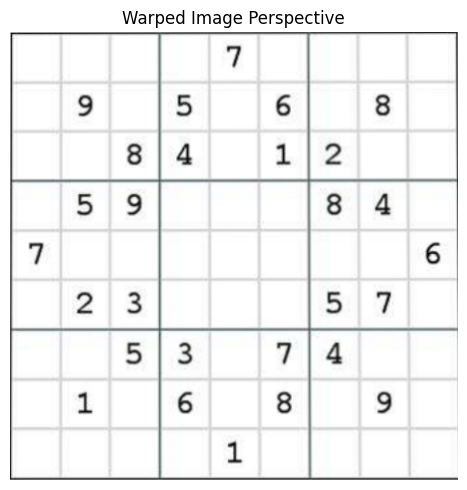

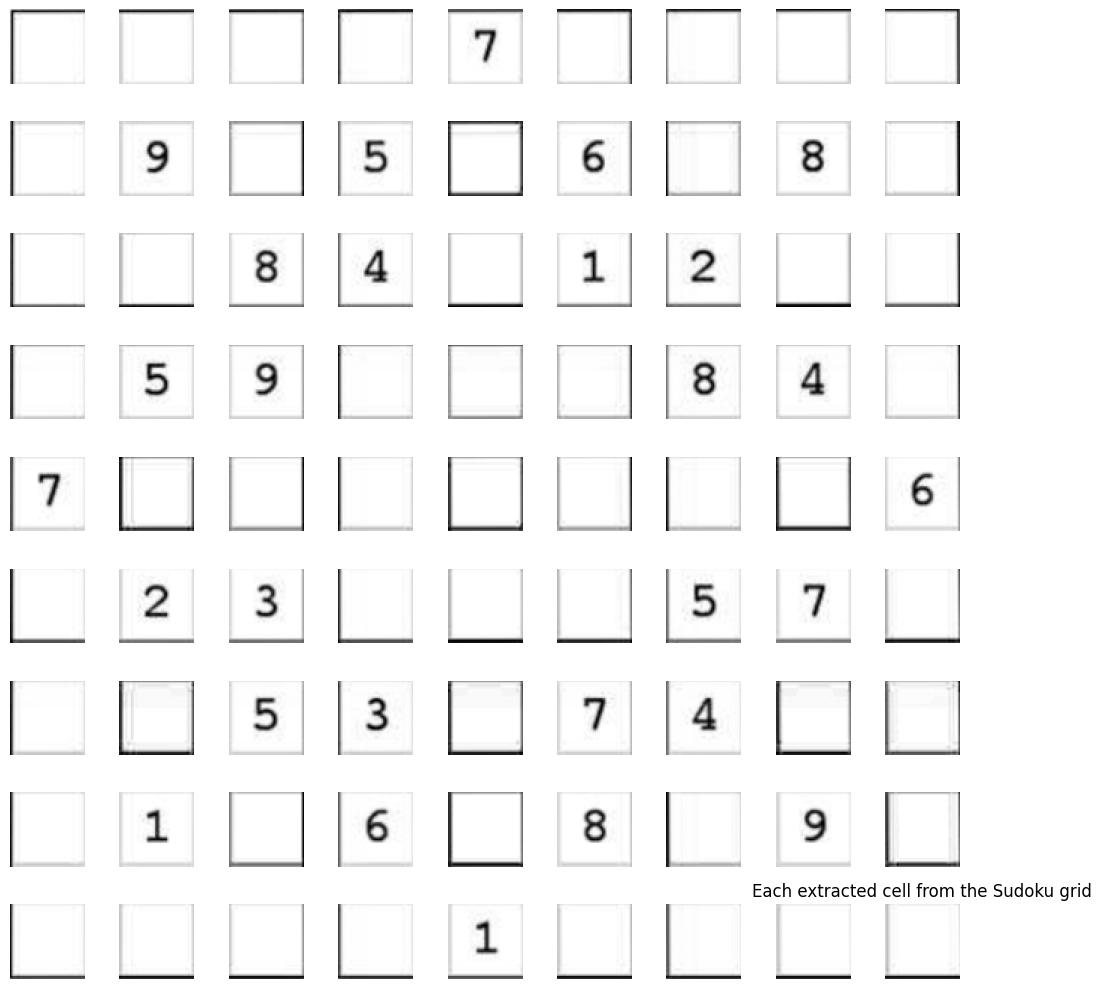

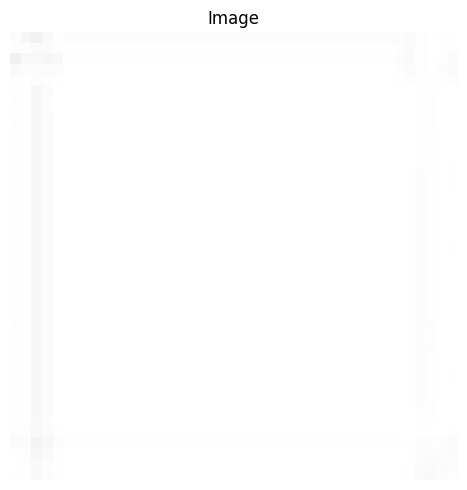

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
[0] 0.39180076


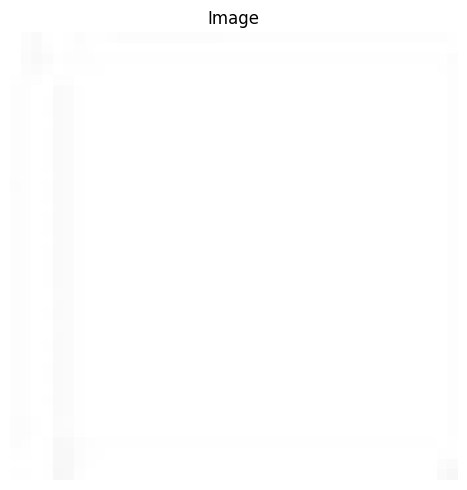

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39179543


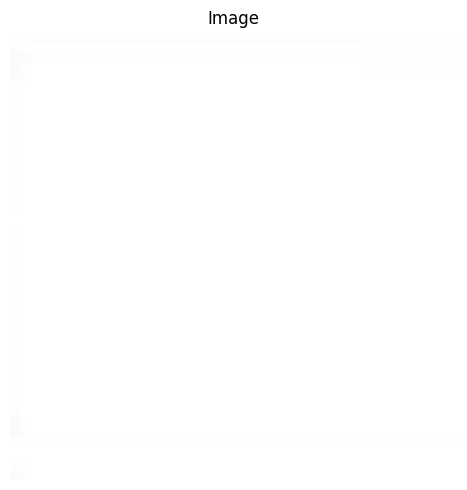

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0] 0.39222094


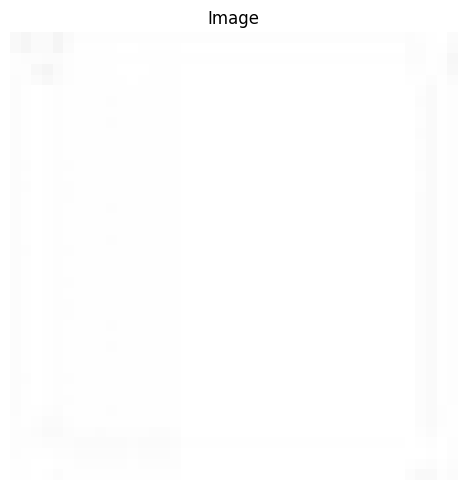

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39150608


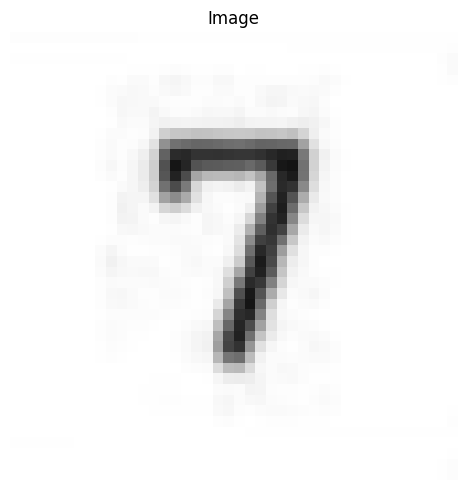

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[7] 0.8755585


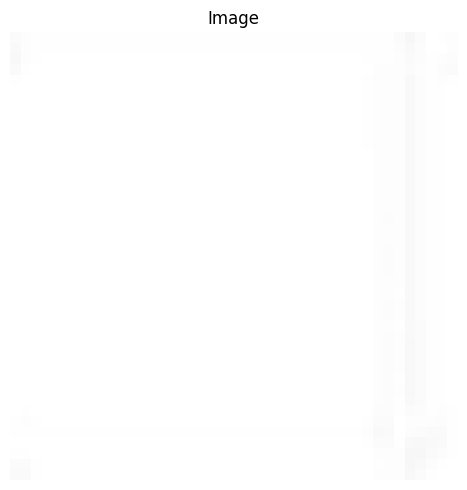

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.3920279


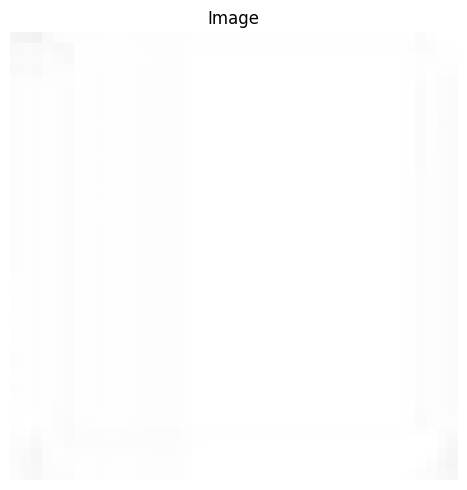

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39114222


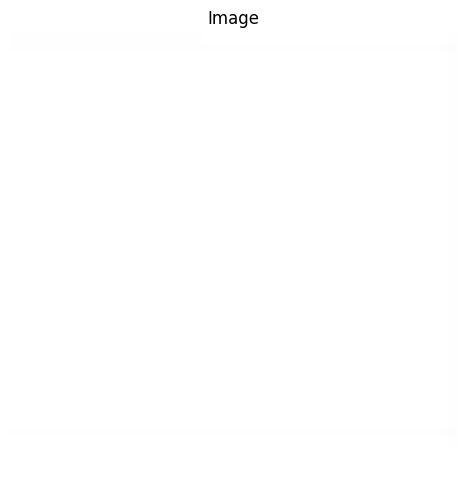

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0] 0.3922096


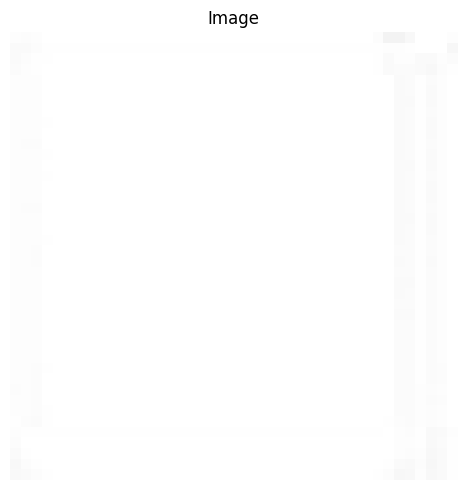

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39198983


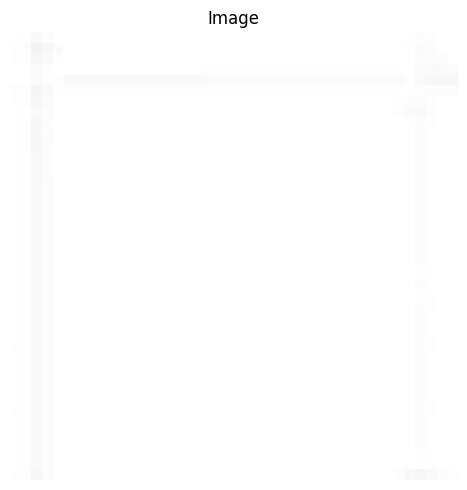

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39225447


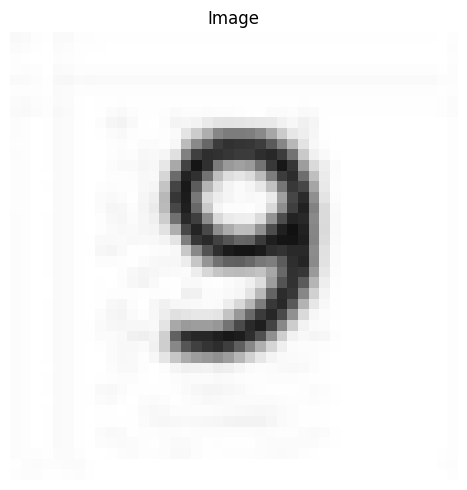

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[9] 0.8854135


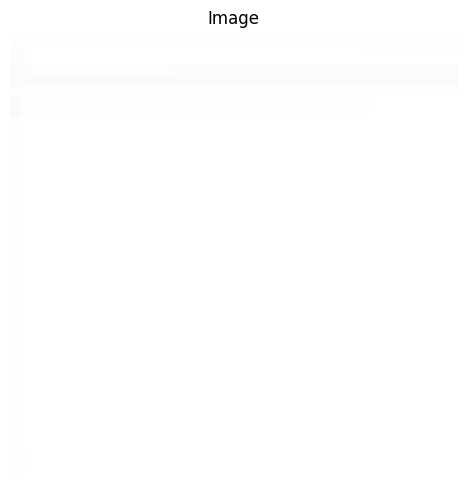

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0] 0.39244533


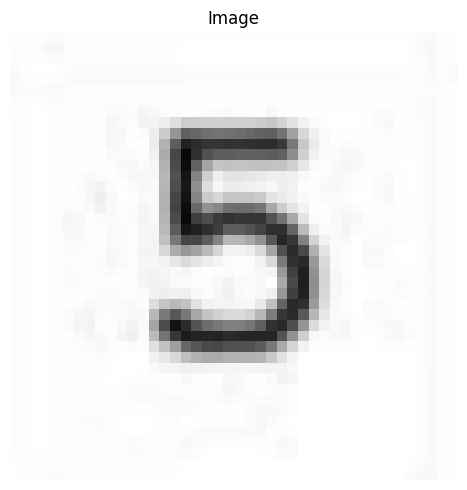

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[5] 0.97406673


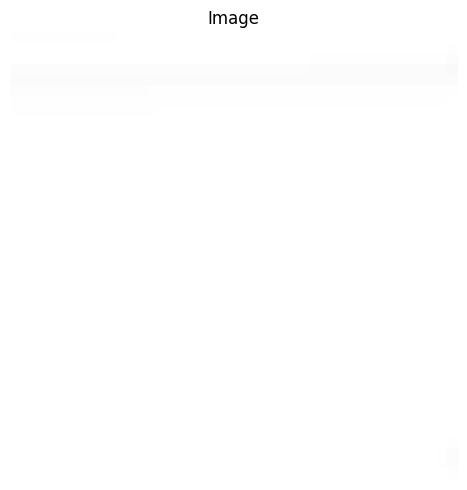

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39251


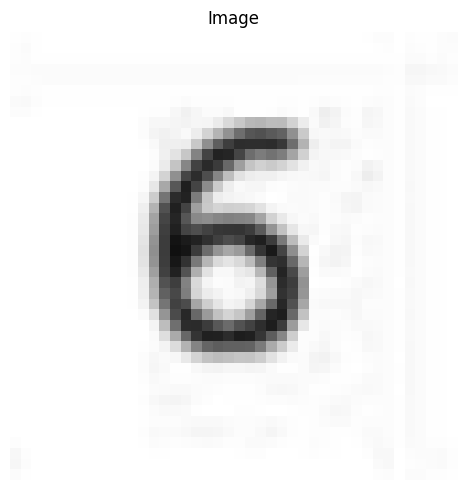

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[6] 0.7807388


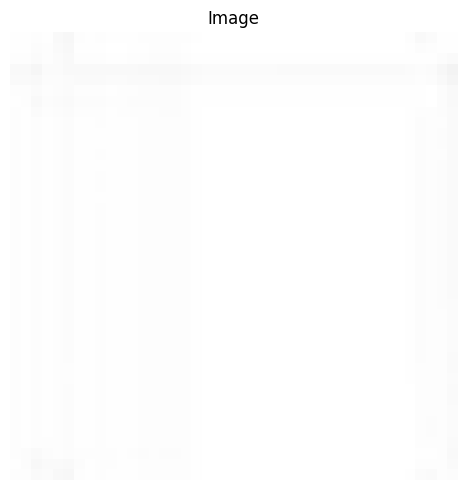

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0] 0.3906894


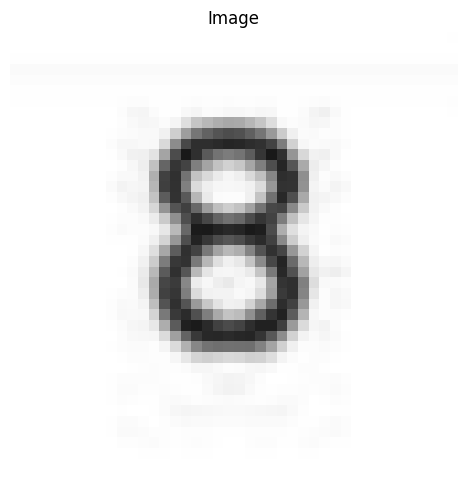

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[8] 0.61574674


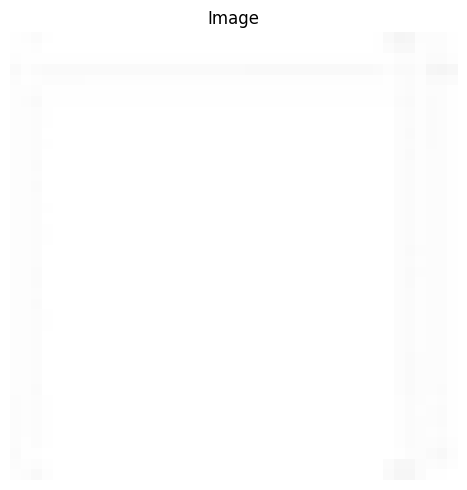

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.3919974


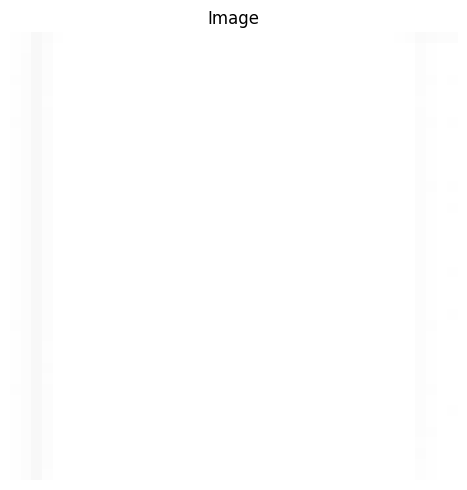

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39173138


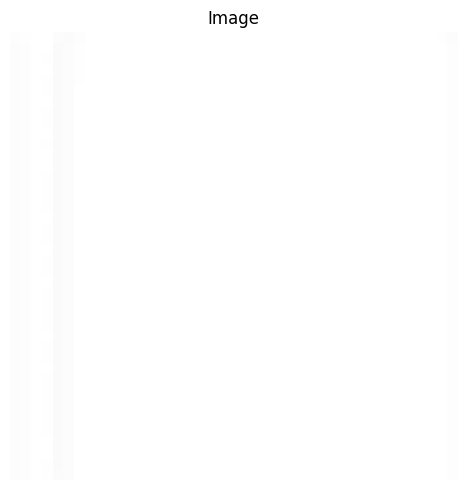

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0] 0.39155334


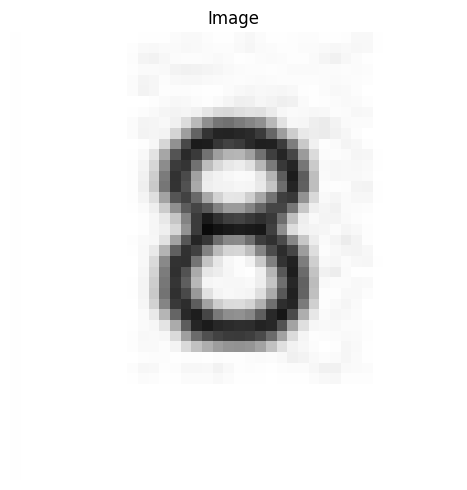

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[8] 0.5674954


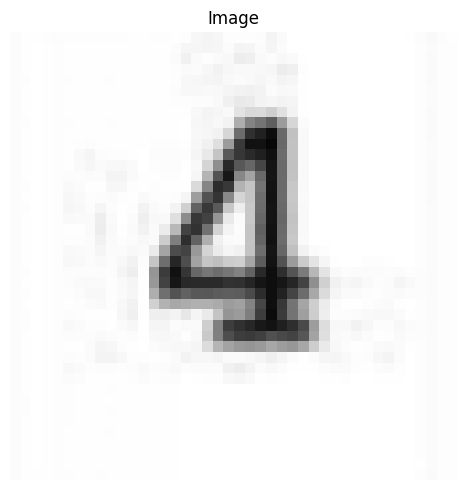

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[4] 0.8314376


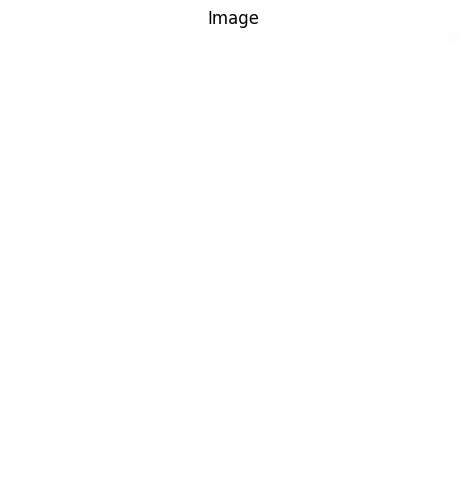

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0] 0.39210662


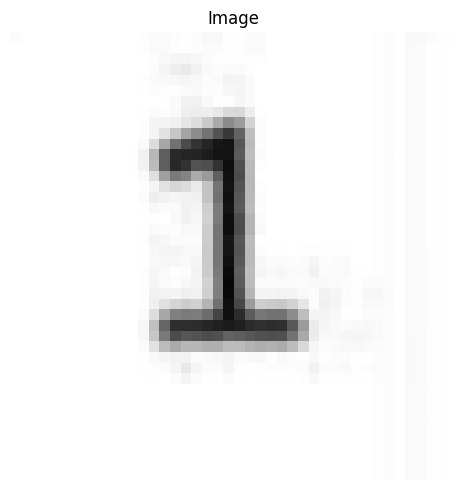

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[1] 0.8112922


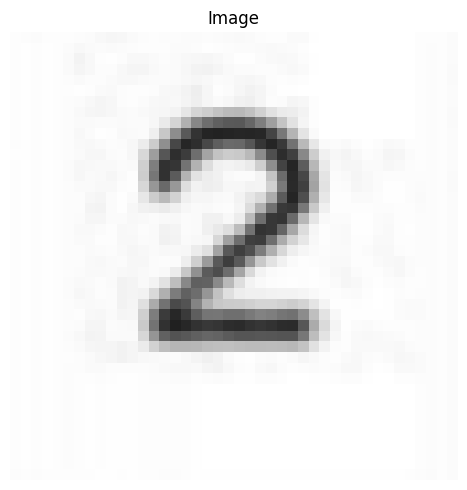

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[2] 0.93386245


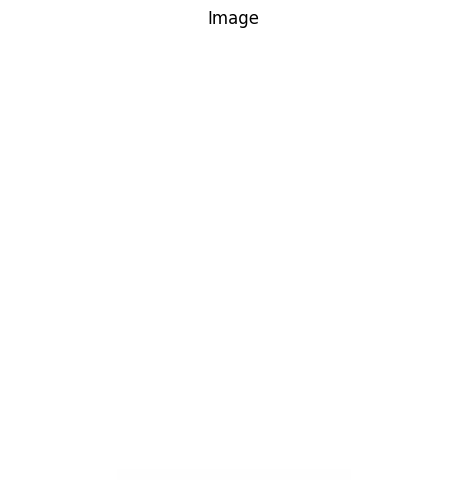

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0] 0.39210886


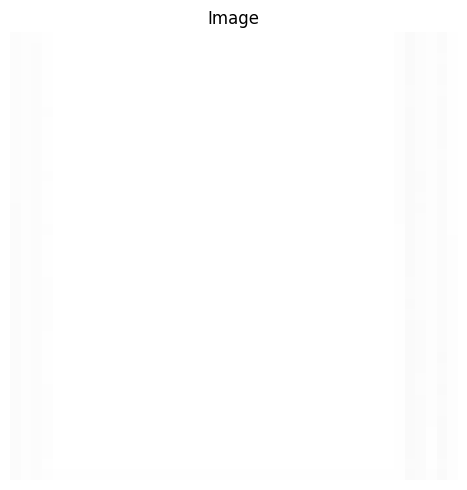

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39186293


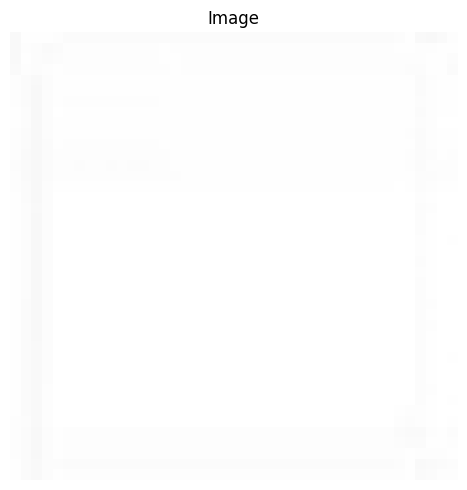

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.3922267


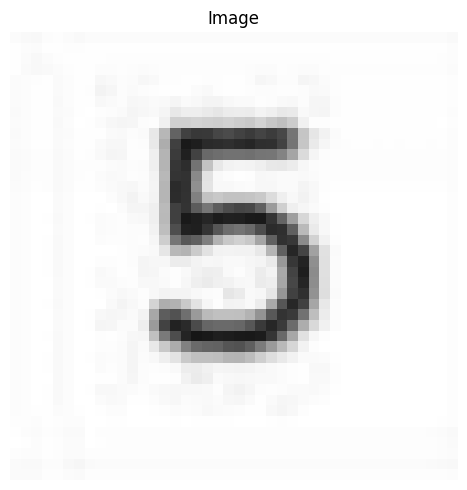

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[5] 0.9811871


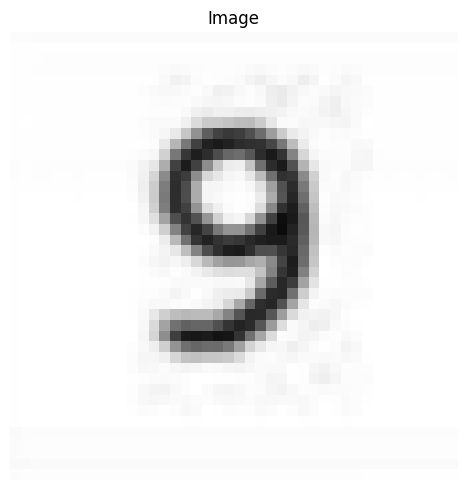

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[9] 0.8860847


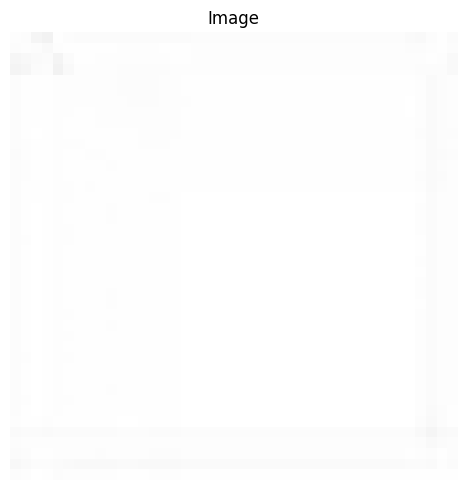

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0] 0.39092922


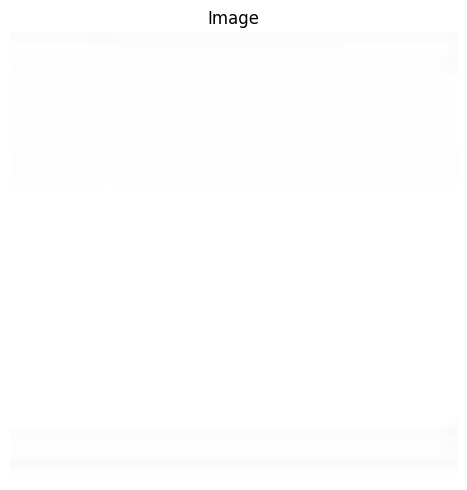

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0] 0.39199722


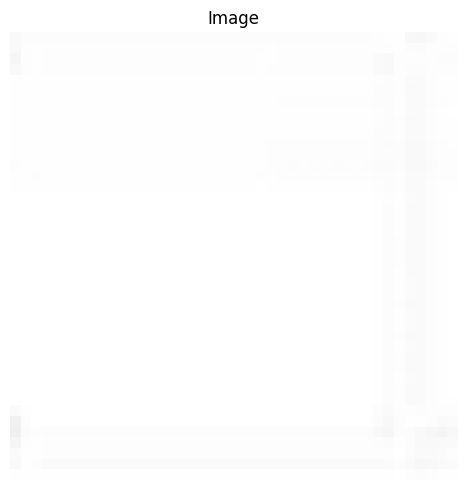

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39143807


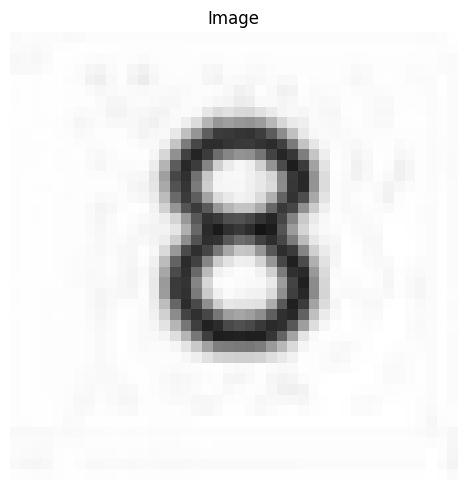

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[8] 0.6177898


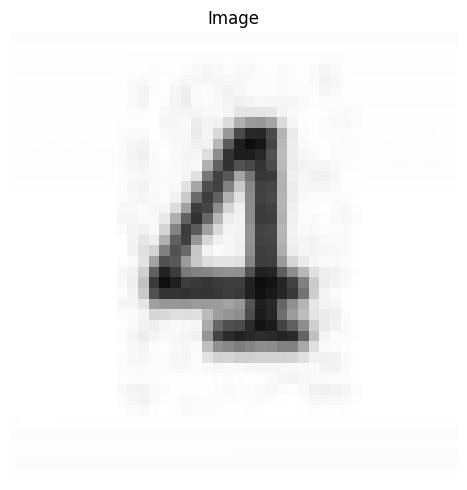

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[4] 0.7921726


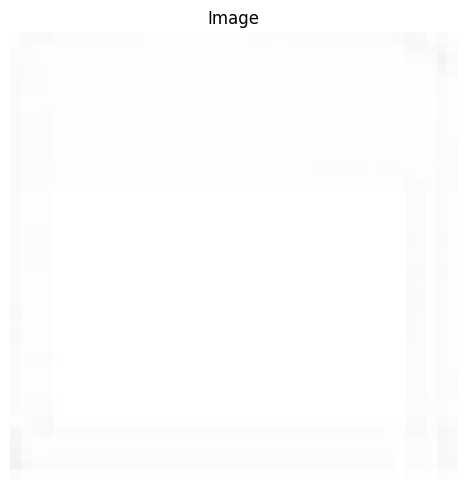

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39144495


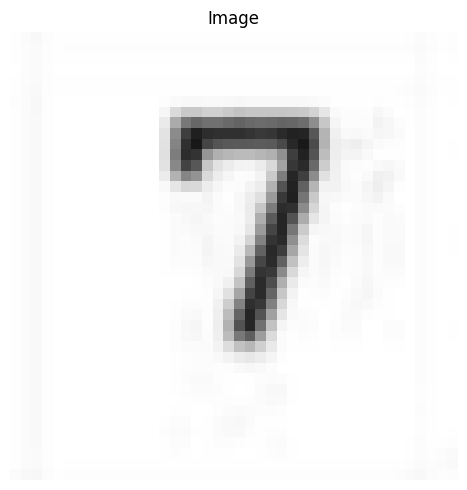

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[7] 0.7825105


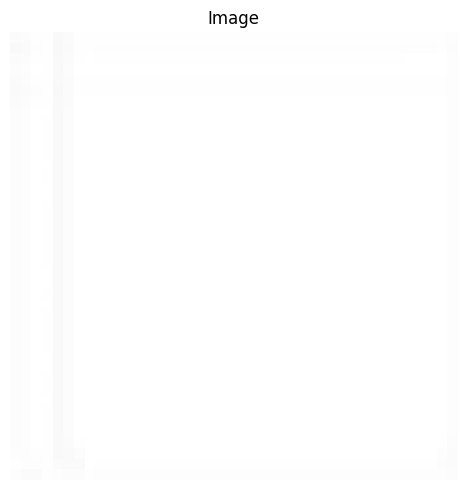

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39159673


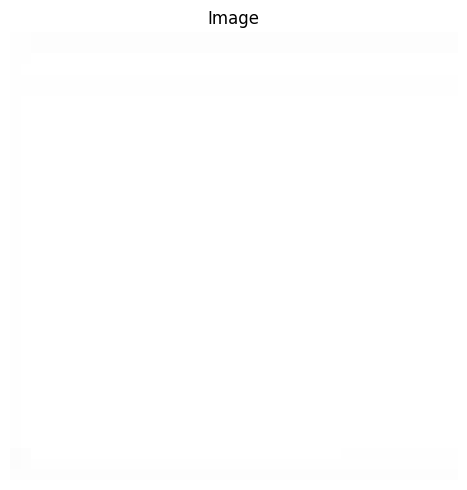

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39218625


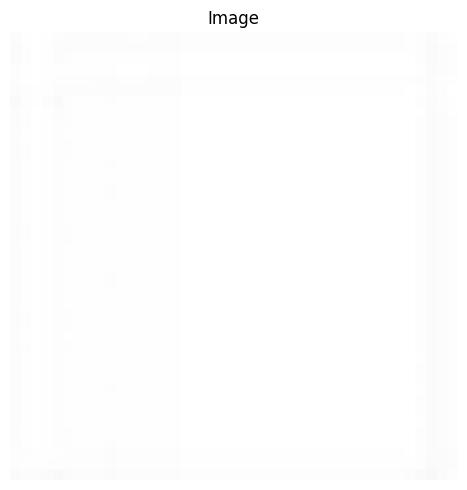

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.3914996


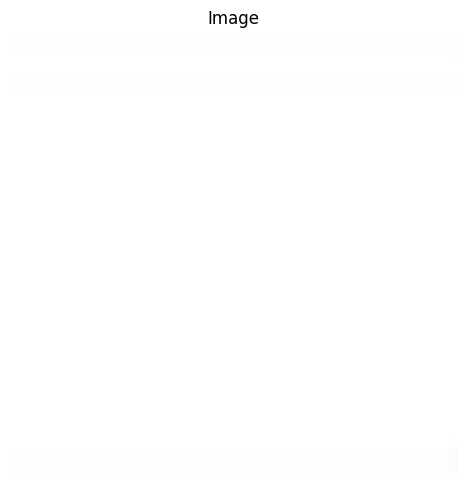

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39218315


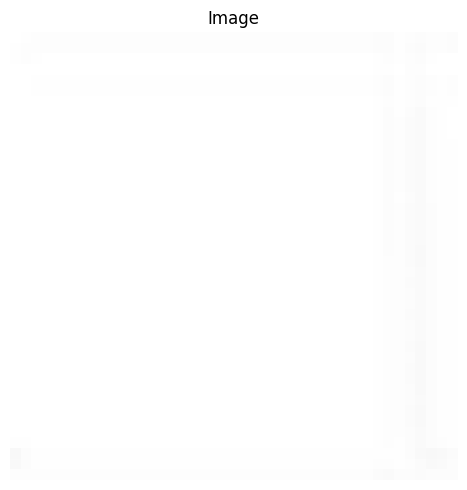

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0] 0.392093


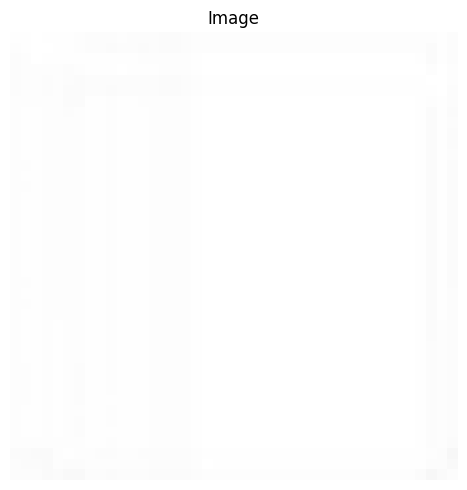

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0] 0.3906741


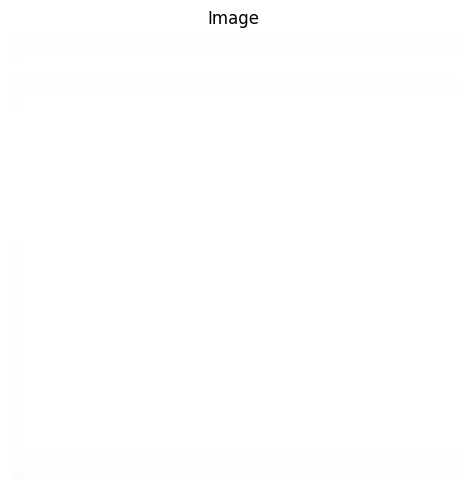

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0] 0.3921873


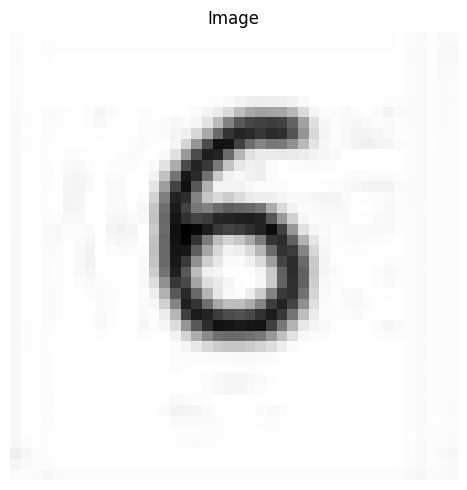

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[6] 0.8434811


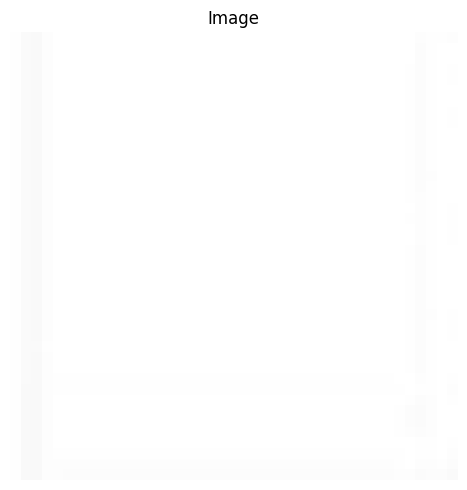

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0] 0.3919542


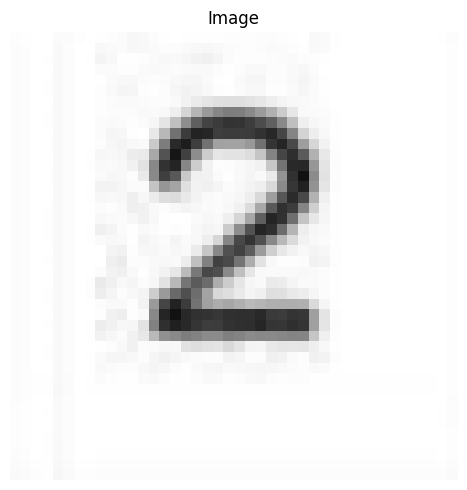

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[2] 0.9378704


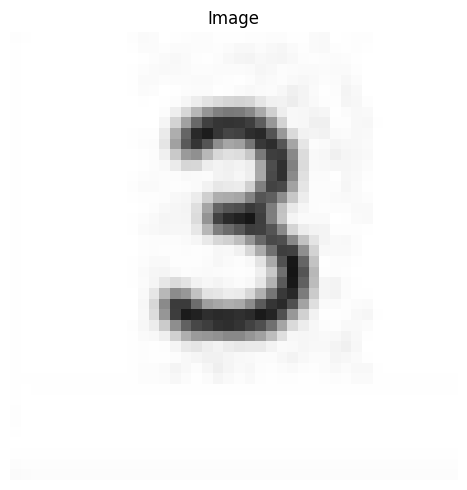

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[3] 0.8032372


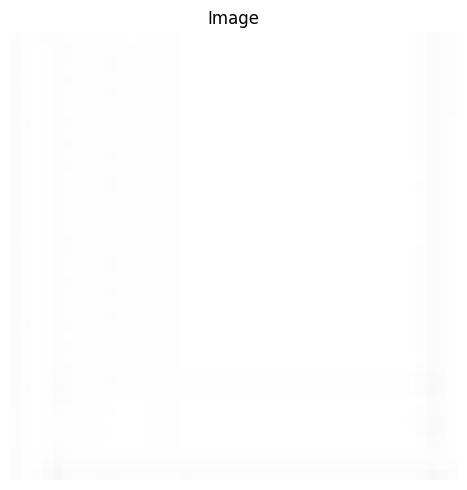

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39138886


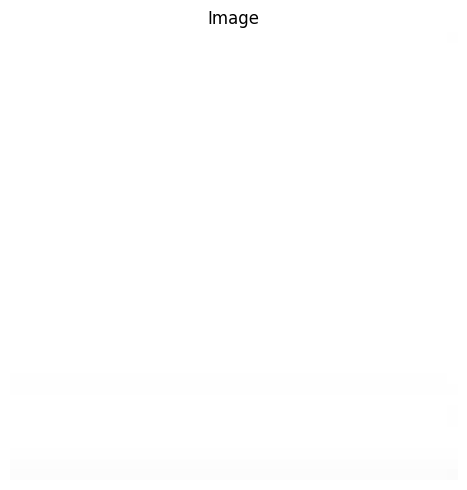

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39226463


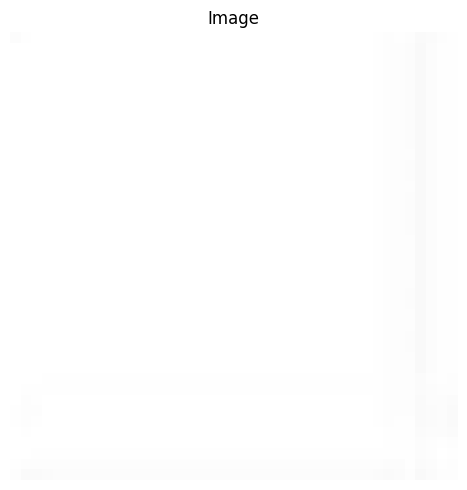

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39216962


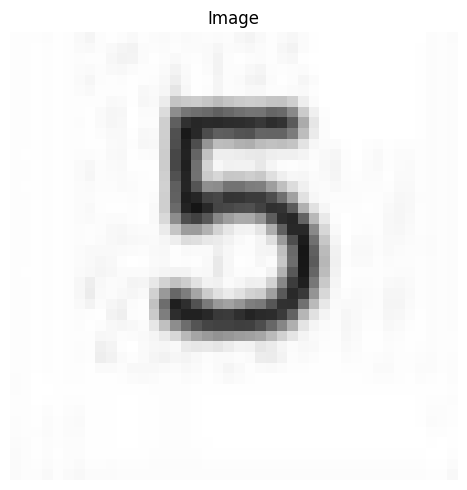

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[5] 0.9616377


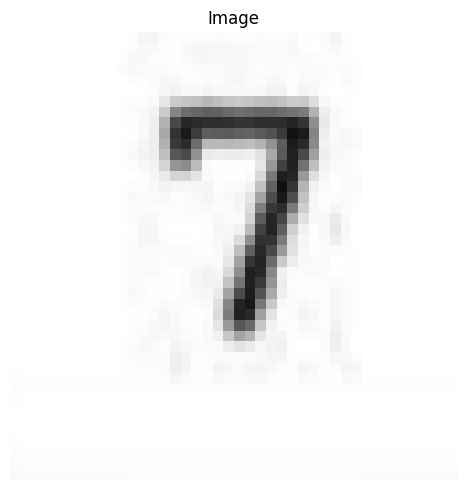

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[7] 0.754185


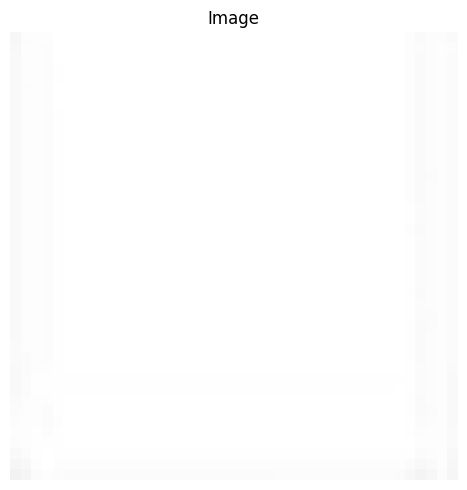

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39188555


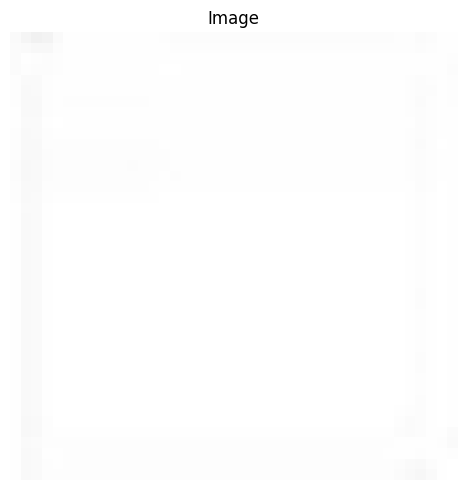

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0] 0.392234


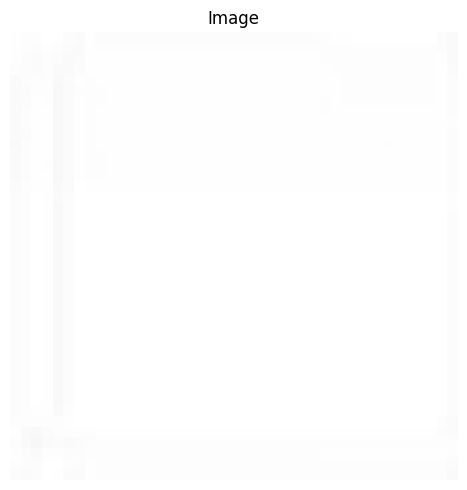

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.3912174


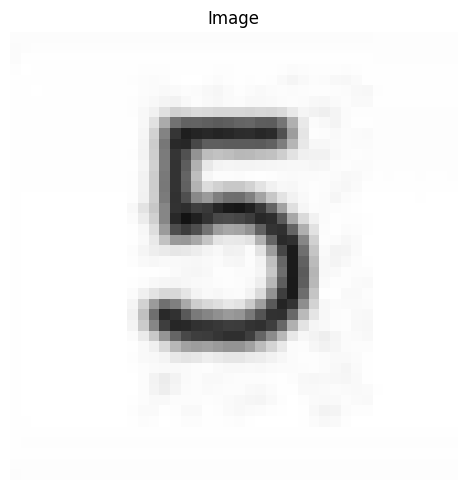

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[5] 0.979119


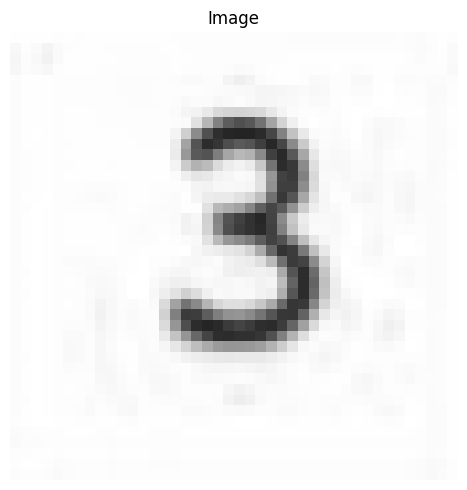

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[3] 0.810826


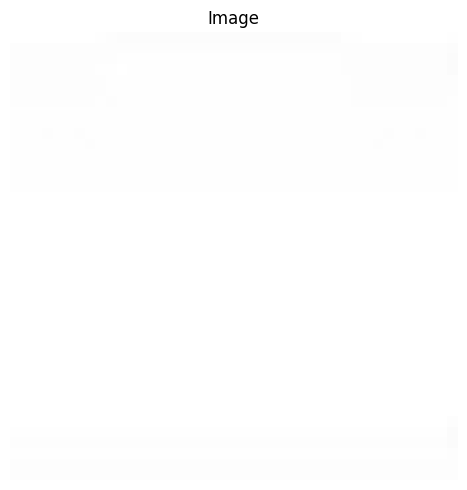

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39161238


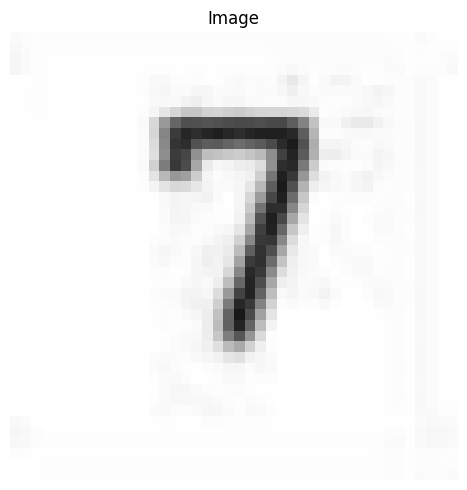

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[7] 0.84217715


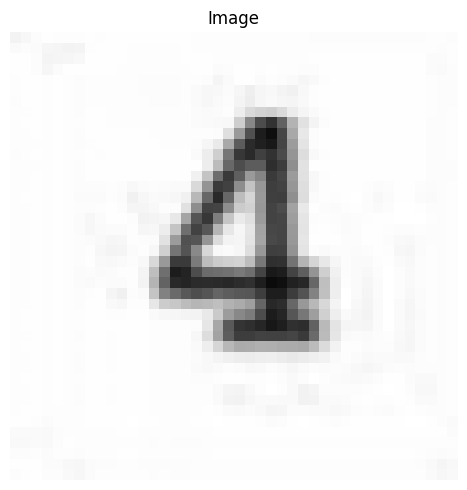

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[4] 0.81025916


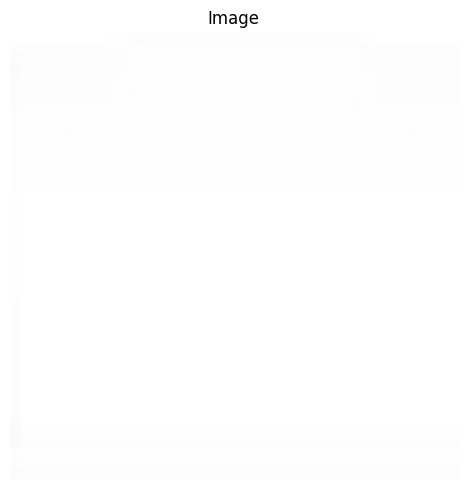

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39162454


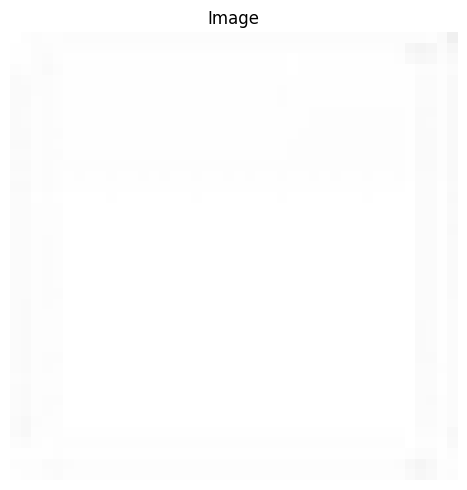

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0] 0.3909901


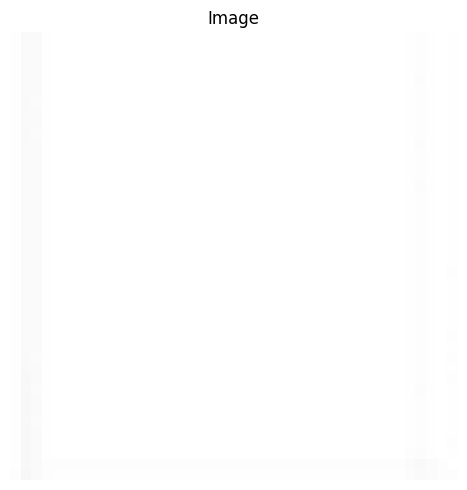

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.3918942


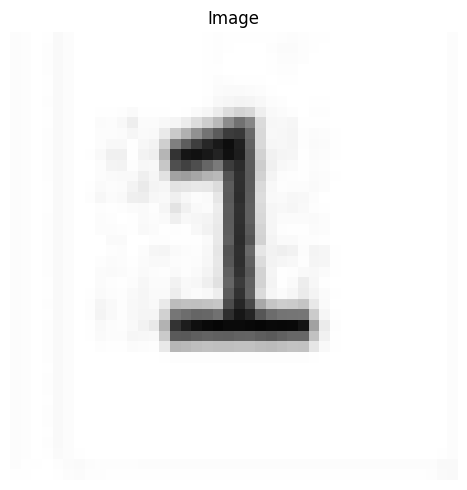

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[1] 0.57293934


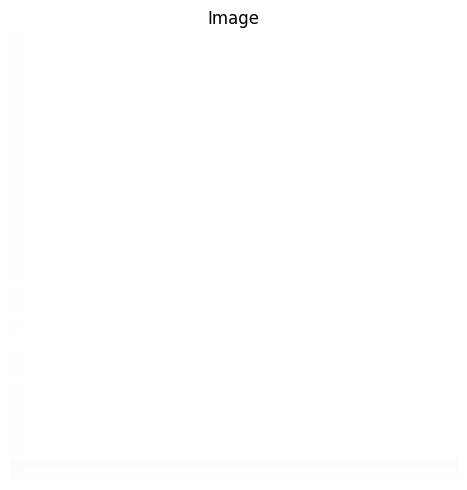

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39211667


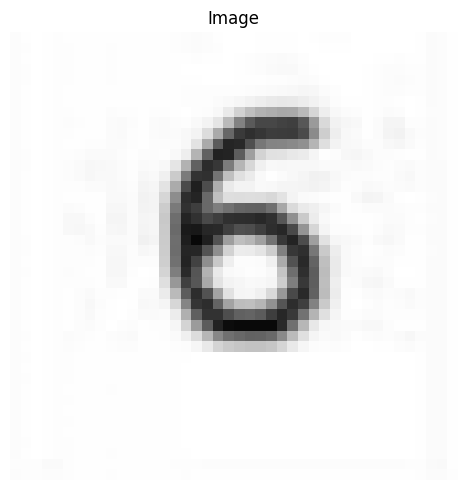

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[6] 0.8201557


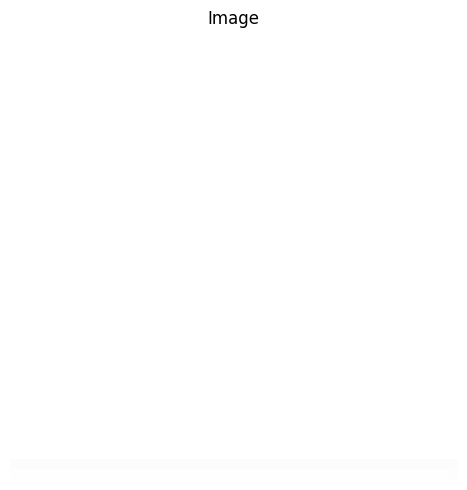

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39211524


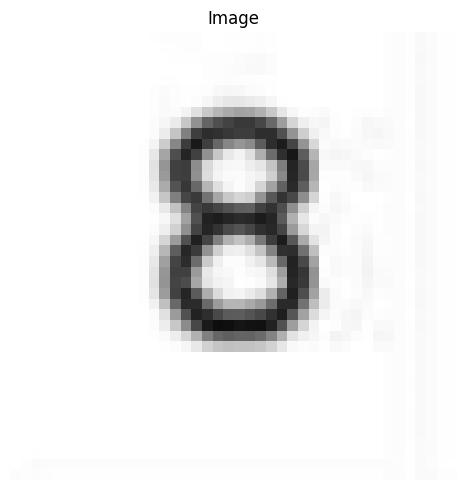

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[8] 0.6071524


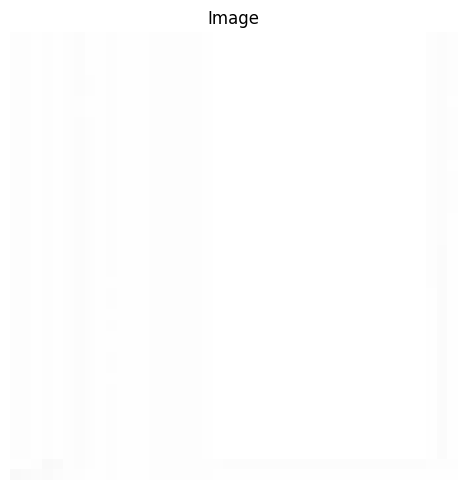

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[0] 0.39002073


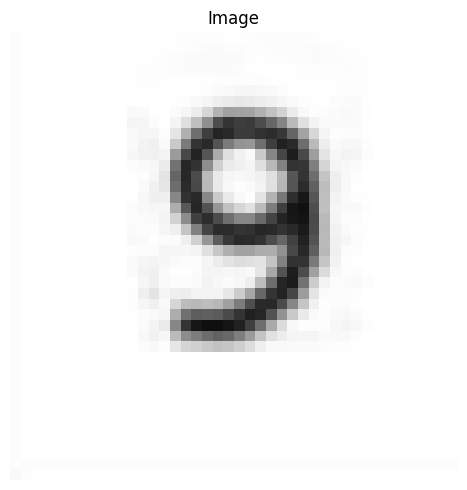

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[9] 0.741632


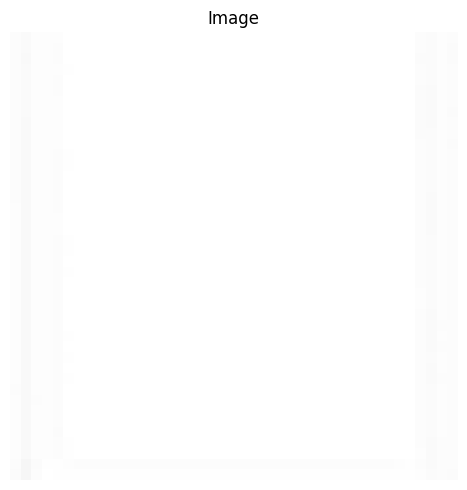

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39167055


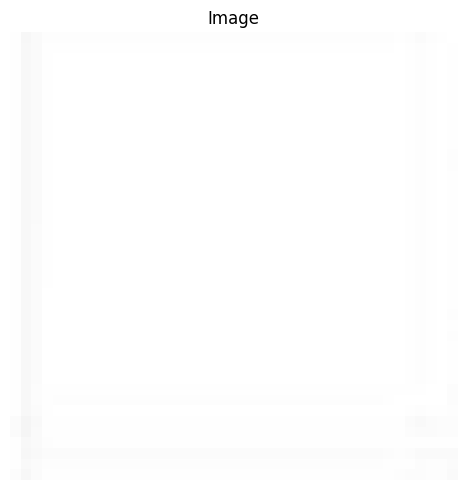

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39240646


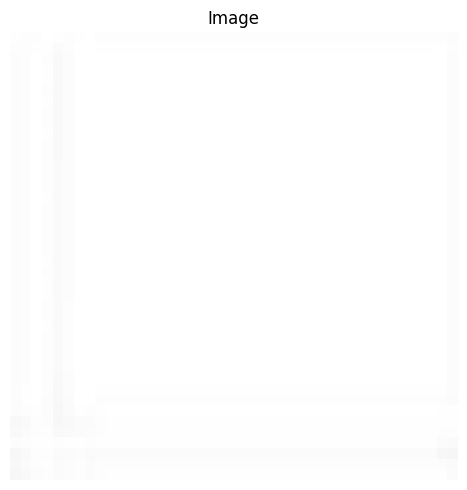

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0] 0.39197615


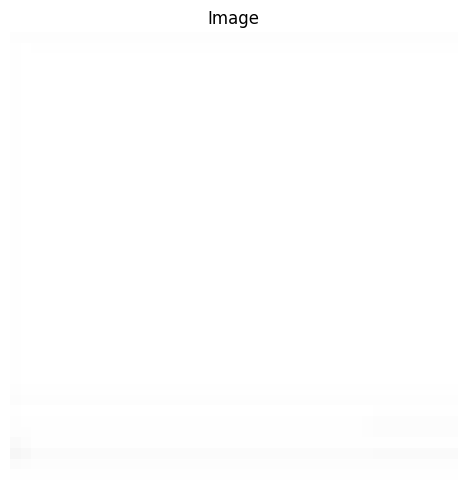

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[0] 0.39256772


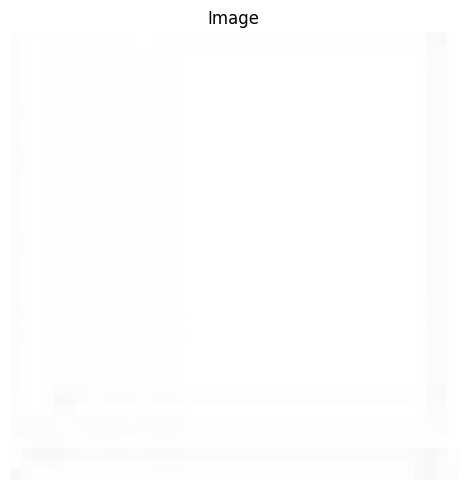

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.3918245


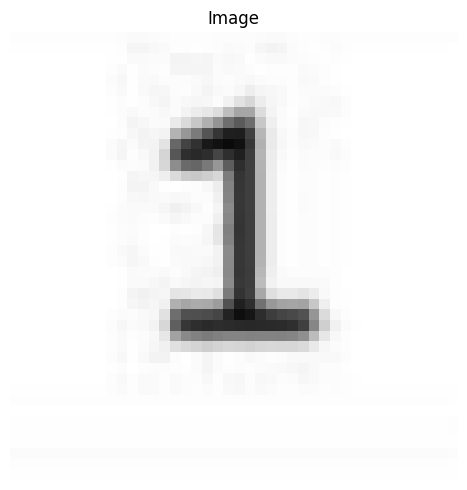

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[1] 0.53099424


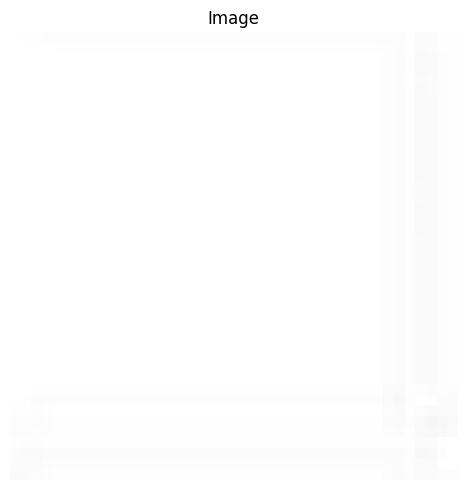

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[0] 0.39244905


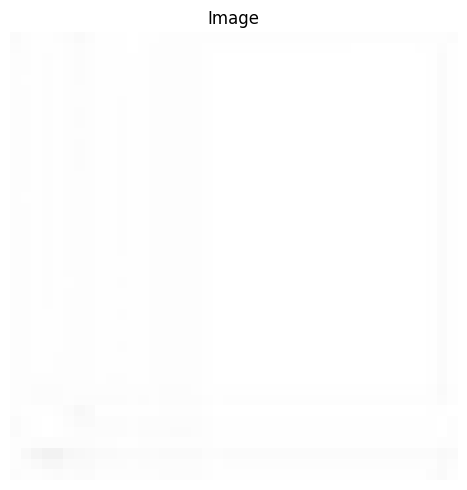

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39047518


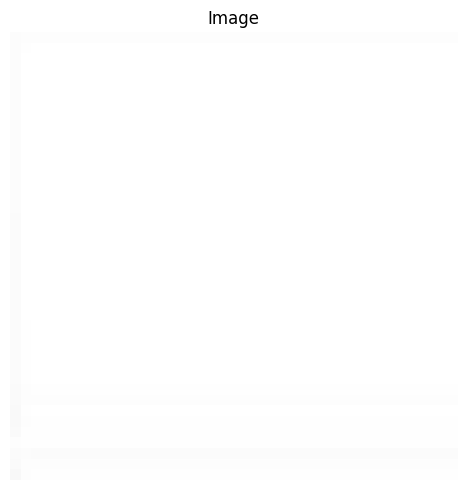

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39253932


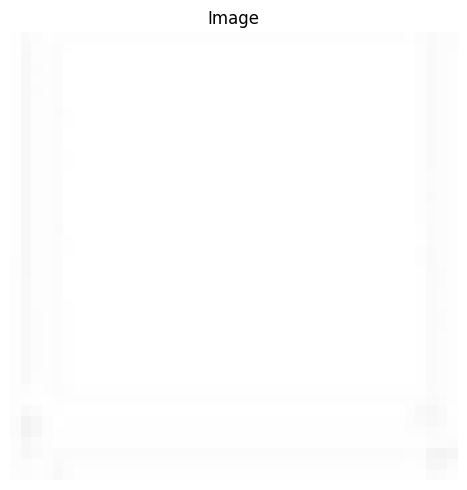

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0] 0.39203712
Numbers Detected
[0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 9, 0, 5, 0, 6, 0, 8, 0, 0, 0, 8, 4, 0, 1, 2, 0, 0, 0, 5, 9, 0, 0, 0, 8, 4, 0, 7, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 3, 0, 0, 0, 5, 7, 0, 0, 0, 5, 3, 0, 7, 4, 0, 0, 0, 1, 0, 6, 0, 8, 0, 9, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


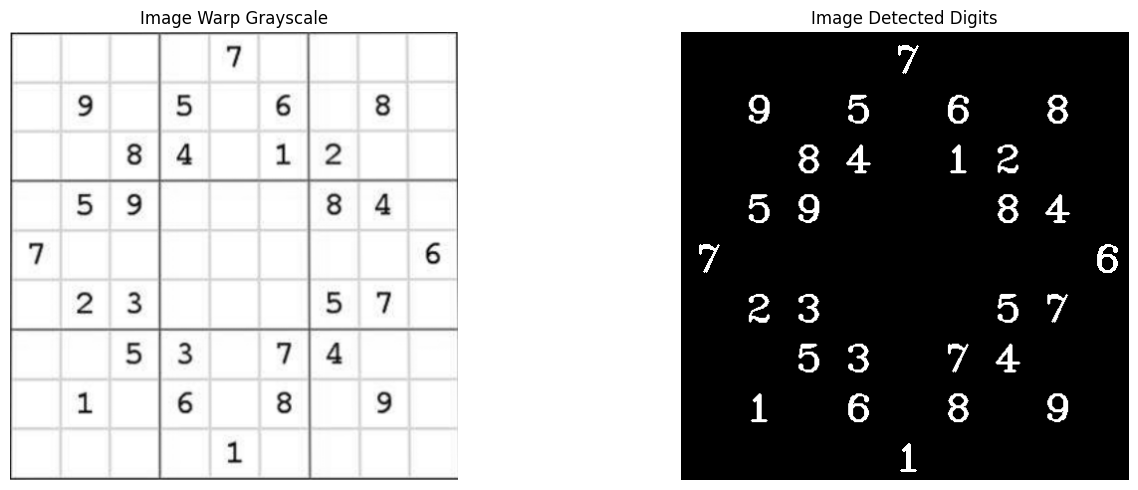

In [6]:
def split_boxes(image):
    rows = np.vsplit(image, 9)
    
    boxes = []
    fig, axes = plt.subplots(9, 9, figsize=(10, 10))
    
    for i, r in enumerate(rows):
        cols = np.hsplit(r, 9)
        for j, box in enumerate(cols):
            boxes.append(box)
      
            axes[i, j].imshow(box, cmap='gray')
            axes[i, j].axis('off')  
    plt.title("Each extracted cell from the Sudoku grid")
    plt.tight_layout()
    plt.show()
    return boxes


def get_prediction(boxes, model):
    confidence_threshold = 0.2
    result = []
    for image in boxes:
        # Sudoku cell preprocessing
        
        image = np.asarray(image)
        image = image[4:image.shape[0] - 4, 4:image.shape[1] - 4] # crops image by 4 pixels to remove potential noise that affects model prediction
        image_array = [image]
        titles = ['Image']
        display_images(image_array, titles=titles, cols=1)
        
        # normalize pixel values and resize images for better training performance
        image = cv2.resize(image, (32, 32))
        image = image / 255
        image = image.reshape(1, 32, 32, 1)
        
       
        
    
        predictions = model.predict(image)
        class_index = np.argmax(predictions, axis=-1)
        probability_value = np.amax(predictions)
        print(class_index, probability_value)
        
    
        if probability_value > confidence_threshold:
            result.append(class_index[0])
        else:
            result.append(0)
            
    return result


def display_numbers(image, numbers, color = (255, 255, 255)):
    # width and height of each grid section cell by dividing the image width by 9 (for 9 columns)
    # .shape returns rows,cols
    width = int(image.shape[1]/9)
    height = int(image.shape[0]/9)
    for x in range(0,9):
        for y in range(0,9):
            if numbers[(y*9)+x] != 0:
                # display the number in the center of the cell, centering the number horizontally and vertically slighty off-center
                cv2.putText(image, str(numbers[(y*9)+x]),
                           (x*width+int(width/2)-10, int((y+0.8)*height)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                           2, color, 2)
    return image



if biggest.size != 0:
    pts1 = np.float32(biggest) #preparing for warp perspective
    pts2 = np.float32([[0,0], [width, 0], [0, height], [width, height]]) # (top left, top right, bottom left, bottom right)
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    
  
    
    image_warp_perspective = cv2.warpPerspective(image, matrix, (width, height))

    image_array = [image_warp_perspective]
    titles = ["Warped Image Perspective"]
    display_images(image_array, titles=titles, cols=1)
    
    image_detected_digits = blank_image.copy()
    image_warp_gray = cv2.cvtColor(image_warp_perspective, cv2.COLOR_BGR2GRAY)
    

  

    boxes = split_boxes(image_warp_gray)



    numbers = get_prediction(boxes, model)
    print("Numbers Detected")
    print(numbers)
    image_detected_digits = display_numbers(image_detected_digits, numbers, color=(255,255,255))
    numbers = np.asarray(numbers)
    
    non_detected_digits_array = np.where(numbers > 0, 0, 1)
    
    
    
image_array = [image_warp_gray, image_detected_digits]
titles = ["Image Warp Grayscale", "Image Detected Digits"]
display_images(image_array, titles=titles, cols=2)
    

# Solution of Sudoku Puzzle

In [7]:
def solve(board):
    """
    solves the Sudoku puzzle using a recursive backtracking approach.
    
    Parameters:
        board (2D list): A 9x9 Sudoku board where empty cells are represented by 0
    
    Returns:
        bool: True if the board is solved, False if no solution exists.
    """
    # find empty cell (0)
    find = find_empty(board)
    
    # no empty cell is found, the board is solved
    if not find:
        return True
    else:
        row, col = find  

    # trying digits 1 to 9 in the empty cell
    for num in range(1, 10):
        
        # check if placing the digit is valid
        if valid(board, num, (row, col)):
            board[row][col] = num 
            
            # recursively attempt to solve the board with new digit
            if solve(board):
                return True  # solved, return True
            
            # try next digit
            board[row][col] = 0
    
    # no digit from 1 to 9 leads to a solution,  invalid puzzle, return False
    return False

def valid(board, num, pos):
    """
    Checks whether placing a number at a given position is valid according to Sudoku rules.
    
    Parameters:
        board (2D list): 9x9 Sudoku board
        num (int): number to place on the board
        pos (tuple): position (row, col) where the number is to be placed
    
    Returns:
    bool: True if the number can be placed at the position, False otherwise.
    """
    row, col = pos
    
    # check if the number already exists in the same row
    for i in range(9):
        if board[row][i] == num and col != i:
            return False
    
    # check if the number already exists in the same column
    for i in range(9):
        if board[i][col] == num and row != i:
            return False
    
    # check if the number already exists in the 3x3 box containing the position
    box_x = col // 3
    box_y = row // 3
    for i in range(box_y * 3, box_y * 3 + 3):
        for j in range(box_x * 3, box_x * 3 + 3):
            if board[i][j] == num and (i, j) != pos:
                return False
    
    # number is not found in the row, column, or box, so valid, return True
    return True

def find_empty(board):
    """
    Finds the next empty cell on the board.
    
    Parameters:
        board (2D list): The 9x9 Sudoku board
    
    Returns:
        tuple: position (row, col) of the next empty cell. Returns None if no empty cell is found, the puzzle is solved.
    """
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:  # check if the position of cell is empty
                return (i, j) 
    return None  # return None if no empty cell is found, Sudoku is solved



if biggest.size != 0:

    
    board = np.array_split(numbers, 9)
    print("Sudoku Board")
    print(board)
    try:
        solve(board)
    except:
        pass

    all_digits = []
    print("Solved Sudoku Board")
    print(board)
    for sublist in board:
        for item in sublist:
            all_digits.append(item)
    print(all_digits)
    solved_numbers = all_digits*non_detected_digits_array
    print(solved_numbers)
    image_solved_digits = blank_image.copy()
    image_solved_digits = display_numbers(image_solved_digits, solved_numbers, color=(0, 255, 0))







Sudoku Board
[array([0, 0, 0, 0, 7, 0, 0, 0, 0]), array([0, 9, 0, 5, 0, 6, 0, 8, 0]), array([0, 0, 8, 4, 0, 1, 2, 0, 0]), array([0, 5, 9, 0, 0, 0, 8, 4, 0]), array([7, 0, 0, 0, 0, 0, 0, 0, 6]), array([0, 2, 3, 0, 0, 0, 5, 7, 0]), array([0, 0, 5, 3, 0, 7, 4, 0, 0]), array([0, 1, 0, 6, 0, 8, 0, 9, 0]), array([0, 0, 0, 0, 1, 0, 0, 0, 0])]
Solved Sudoku Board
[array([2, 3, 6, 8, 7, 9, 1, 5, 4]), array([4, 9, 1, 5, 2, 6, 3, 8, 7]), array([5, 7, 8, 4, 3, 1, 2, 6, 9]), array([1, 5, 9, 7, 6, 2, 8, 4, 3]), array([7, 8, 4, 1, 5, 3, 9, 2, 6]), array([6, 2, 3, 9, 8, 4, 5, 7, 1]), array([8, 6, 5, 3, 9, 7, 4, 1, 2]), array([3, 1, 2, 6, 4, 8, 7, 9, 5]), array([9, 4, 7, 2, 1, 5, 6, 3, 8])]
[2, 3, 6, 8, 7, 9, 1, 5, 4, 4, 9, 1, 5, 2, 6, 3, 8, 7, 5, 7, 8, 4, 3, 1, 2, 6, 9, 1, 5, 9, 7, 6, 2, 8, 4, 3, 7, 8, 4, 1, 5, 3, 9, 2, 6, 6, 2, 3, 9, 8, 4, 5, 7, 1, 8, 6, 5, 3, 9, 7, 4, 1, 2, 3, 1, 2, 6, 4, 8, 7, 9, 5, 9, 4, 7, 2, 1, 5, 6, 3, 8]
[2 3 6 8 0 9 1 5 4 4 0 1 0 2 0 3 0 7 5 7 0 0 3 0 0 6 9 1 0 0 7 6 2 0 0 3 


# Displaying Final Progress and Solution
Draw grid lines on the detected digits grid and the solved grid to make it look nicer. Apply the warp perspective [calculated previously](#section1)  and by using the addWeighted() function, we can overlay two images together by calculating the weighted sum of the two images. The parameters of the function also include how much influence the images have on blending and the number added to each sum of the weighted images to adjust brightness (1 does not change brightness significantly)


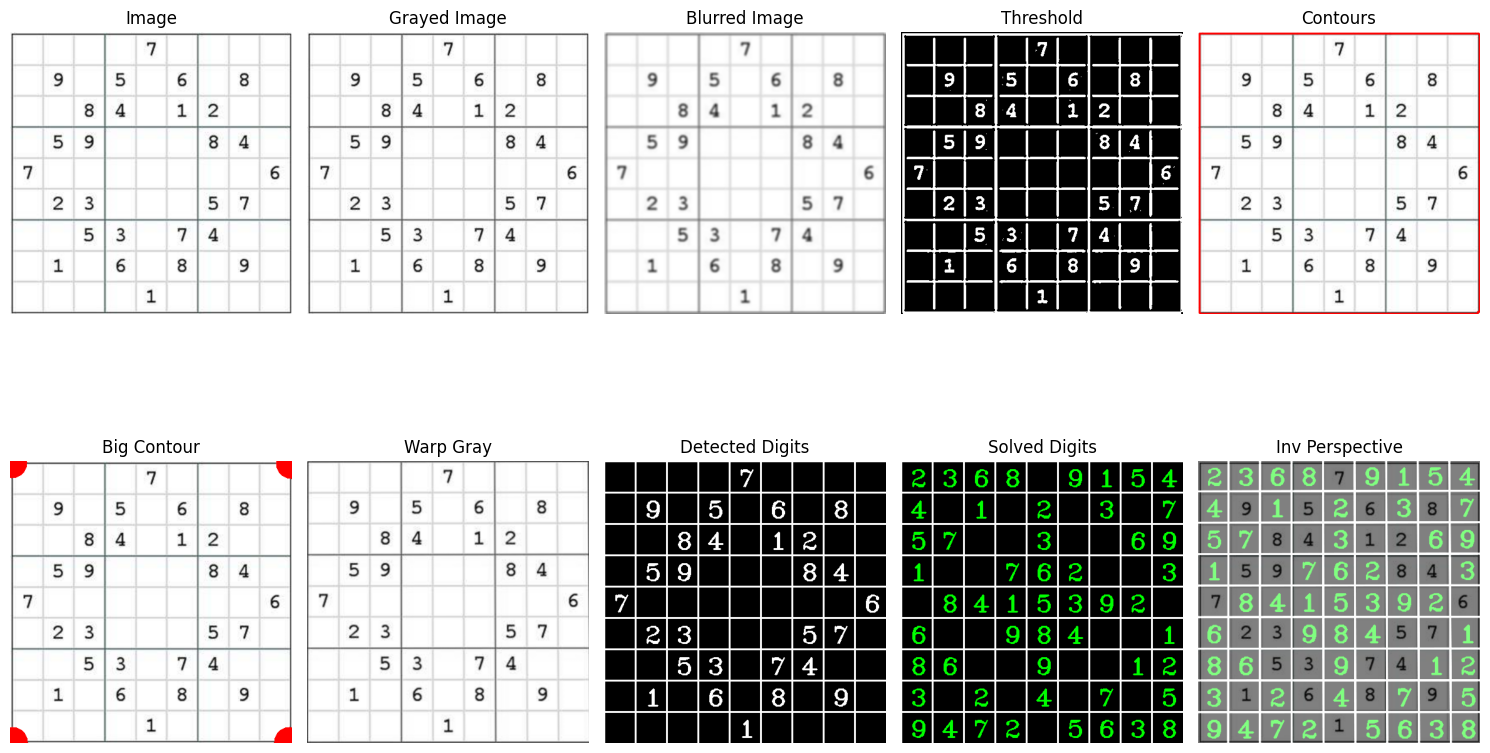

In [8]:

def draw_grid(img):
    width = int(img.shape[1]/9)
    height = int(img.shape[0]/9)
    for i in range (0,9):
        pt1 = (0,height*i)
        pt2 = (img.shape[1],height*i)
        pt3 = (width * i, 0)
        pt4 = (height*i,img.shape[0])
        cv2.line(img, pt1, pt2, (255, 255, 255),2)
        cv2.line(img, pt3, pt4, (255, 255, 255),2)
    return img



if biggest.size != 0:
    
    image_detected_digits_grid = draw_grid(image_detected_digits)
    image_solved_digits_grid = draw_grid(image_solved_digits)
    
    
    img_inv_warp_colored = image.copy()
    img_inv_warp_colored = cv2.warpPerspective(image_solved_digits, matrix, (width, height))
    inv_perspective = cv2.addWeighted(img_inv_warp_colored, 1, image, 0.5, 1)
    

    
    image_array = [image, image_gray, image_blur, image_threshold, image_contours, big_contour_image, 
              image_warp_gray, image_detected_digits_grid, image_solved_digits_grid, inv_perspective]
    titles = ['Image', 'Grayed Image', 'Blurred Image', 'Threshold', 'Contours', 'Big Contour', 
          'Warp Gray', 'Detected Digits', 'Solved Digits', 'Inv Perspective']
    
    display_images(image_array, titles=titles, cols=5)